In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

# Task 1

### Testing

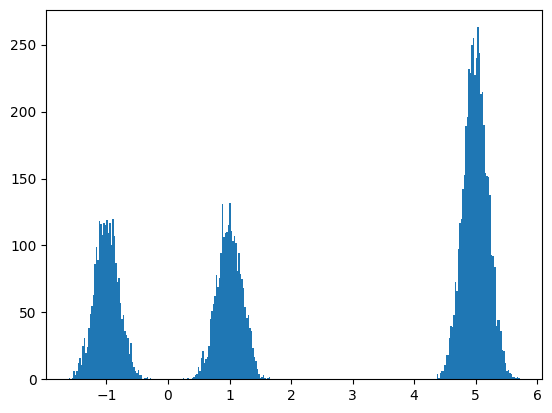

In [3]:
choice_of_gaussian = np.random.choice(3, 10000, p=[0.25, 0.25, 0.5])

zeros = np.zeros(10000)
zeros[choice_of_gaussian == 0] = np.random.normal(-1, 0.2, sum(choice_of_gaussian == 0))
zeros[choice_of_gaussian == 1] = np.random.normal(1, 0.2, sum(choice_of_gaussian == 1))
zeros[choice_of_gaussian == 2] = np.random.normal(5, 0.2, sum(choice_of_gaussian == 2))

plt.hist(zeros, bins=300)
plt.show()

In [4]:
# generate 9 features of 1000 samples form normal distribution
X = np.random.normal(0, 1, (1000, 9))
print(X.shape)

(1000, 9)


In [5]:
y = np.random.choice(2, 10000, p=[0.9, 0.1])

y[zeros > 3] = np.random.choice(2, sum(zeros > 3), p=[0.1, 0.9])

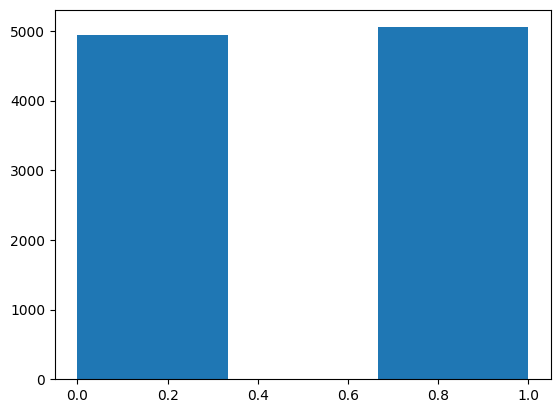

In [6]:
plt.hist(y, bins=3)
plt.show()

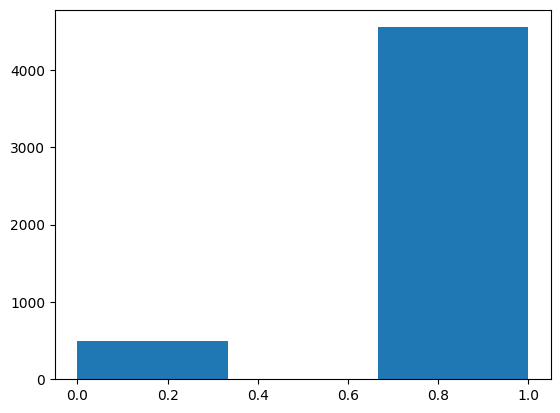

In [7]:
plt.hist(y[zeros > 3], bins=3)
plt.show()

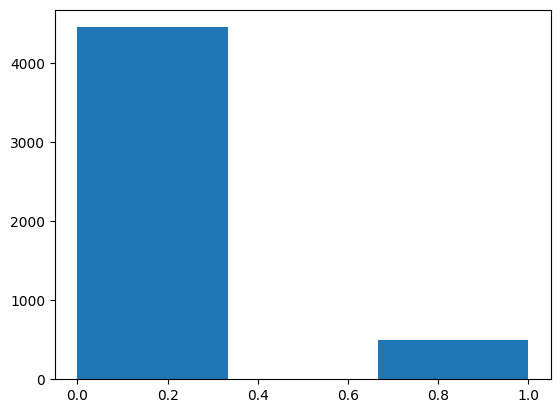

In [8]:
plt.hist(y[zeros < 3], bins=3)
plt.show()

### Function to generate

In [9]:
def generate_data(num_data=1000):
    choice_of_gaussian = np.random.choice(3, num_data, p=[0.25, 0.25, 0.5])

    first_feature = np.zeros(num_data)
    first_feature[choice_of_gaussian == 0] = np.random.normal(
        -1, 0.2, sum(choice_of_gaussian == 0)
    )

    first_feature[choice_of_gaussian == 1] = np.random.normal(
        1, 0.2, sum(choice_of_gaussian == 1)
    )

    first_feature[choice_of_gaussian == 2] = np.random.normal(
        5, 0.2, sum(choice_of_gaussian == 2)
    )

    other_features = np.random.normal(0, 1, (num_data, 9))

    X = np.column_stack((first_feature, other_features))

    y = np.random.choice(2, num_data, p=[0.9, 0.1])

    y[first_feature > 3] = np.random.choice(2, sum(first_feature > 3), p=[0.1, 0.9])

    return X, y

In [10]:
X, y = generate_data(10000)

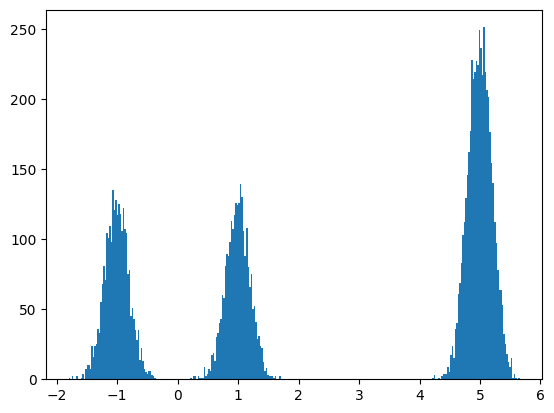

In [11]:
plt.hist(X[:, 0], bins=300)
plt.show()

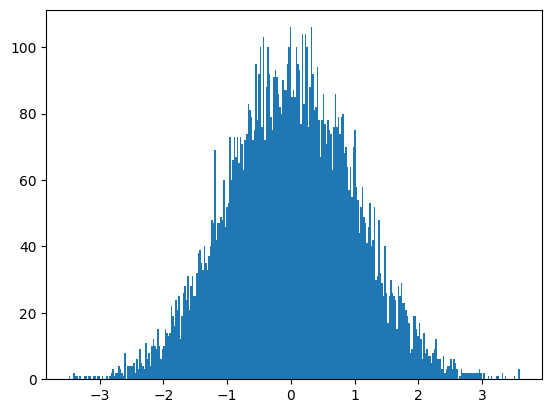

In [12]:
plt.hist(X[:, 2], bins=300)
plt.show()

### Generate test and train

In [13]:
X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(1000)

# Task 2

In [14]:
def predict(X, solution):
    return np.dot(X, solution.T) > 0.5

In [15]:
def accuracy(y, y_pred):
    return sum(y == y_pred.T) / len(y)

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [40]:
def calculate_risk(X, y, current_solution):
    return -np.mean(
        (y + 1) * y * np.dot(X, current_solution.T)
        + np.log(1 - sigmoid(np.dot(X, current_solution.T)) + 1e-14)
    )

In [46]:
def calculate_gradient(X, y, current_solution):
    delta = 0.00001
    gradient = np.zeros(X.shape[1])
    current_solution = current_solution[0]
    risk_before = calculate_risk(X, y, current_solution)
    for i in range(X.shape[1]):
        current_solution[i] += delta
        risk_after = calculate_risk(X, y, current_solution)
        gradient[i] = (risk_after - risk_before) / delta
        current_solution[i] -= delta
    return gradient

In [47]:
def gradient_descent(
    X,
    y,
    X_test,
    y_test,
    initial_solution,
    calculate_gradient,
    learning_rate=0.01,
    max_num_epoch=1000,
):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy().T
        if y.shape[0] == 1:
            y = y[0]
    current_solution = initial_solution
    risk = []
    accuracy_test = []
    accuracy_train = []

    for _ in range(max_num_epoch):
        # logging the risk and accuracy
        risk.append(calculate_risk(X, y, current_solution))
        accuracy_test.append(accuracy(y_test, predict(X_test, current_solution)))
        accuracy_train.append(accuracy(y, predict(X, current_solution)))

        # actual GD step
        gradient = calculate_gradient(X, y, current_solution)
        current_solution = current_solution - learning_rate * gradient
    return current_solution, risk, accuracy_test, accuracy_train

In [48]:
initial_solution = np.zeros((1, X.shape[1]))
learning_rate = 0.01
number_of_epoch = 1000

print("Initial solution:", initial_solution)
solution, risk, accuracy_test, accuracy_train = gradient_descent(
    X_train,
    y_train,
    X_test,
    y_test,
    initial_solution,
    calculate_gradient,
    learning_rate,
    number_of_epoch,
)
print("Solution:", solution)

Initial solution: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Solution: [[ 3.28739234e+01  9.37425984e-02  1.64730309e-02  4.18348393e-01
   2.05481586e-01 -5.96508457e-01 -8.72633940e-04 -1.44598592e-01
  -1.88512389e-01  3.01331436e-01]]


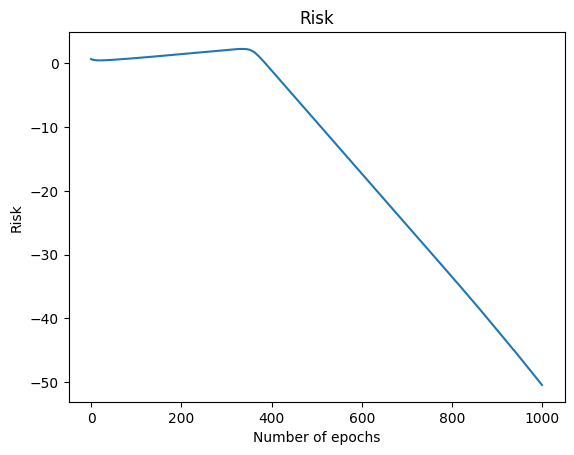

In [49]:
plt.plot(risk)
plt.title("Risk")
plt.ylabel("Risk")
plt.xlabel("Number of epochs")
plt.show()

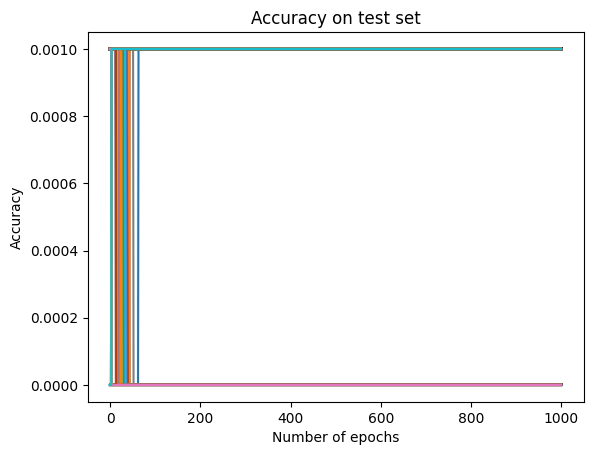

In [45]:
plt.plot(accuracy_test, label="Test")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy on test set")
plt.show()

In [ ]:
accuracy_train

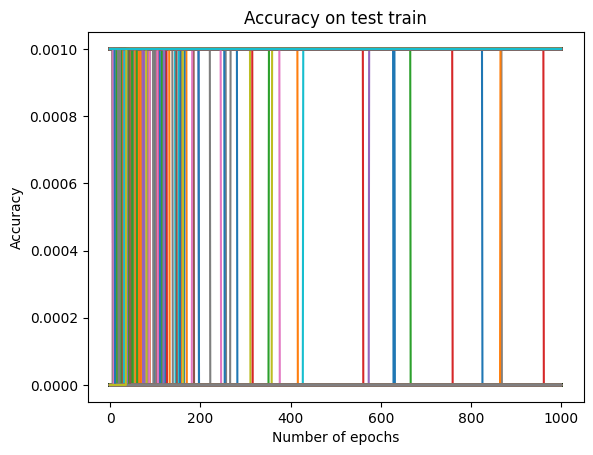

In [232]:
plt.plot(accuracy_train, label="train")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy on test train")
plt.show()

# Task 3

In [89]:
mixture = X_train[:, 0]

## my own implementation of kde

In [97]:
class kde:
    __slots__ = ["kernel_type", "bandwidth", "data", "n"]

    def __init__(self, kernel_type="gaussian", bandwidth=1):
        self.kernel_type = kernel_type
        self.bandwidth = bandwidth

    def fit(self, data):
        self.data = data
        self.n = len(data)

    @abstractmethod
    def gaussian_kernel(self, x, mean, std):
        return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))

    @abstractmethod
    def top_hat_kernel(self, x, mean, std):
        return (np.abs(x - mean) <= std) / (2 * std)

    @abstractmethod
    def epanechnikov_kernel(self, x, mean, std):
        return 3 / 4 * (1 - ((x - mean) / std) ** 2) * (np.abs(x - mean) <= std) / std

    @abstractmethod
    def exponential_kernel(self, x, mean, std):
        return np.exp(-np.abs(x - mean) / std) / (2 * std)

    def transform(self, x):
        if not isinstance(x, np.ndarray):
            x = np.array([x])
        solution = np.zeros(len(x))
        for data_point in self.data:
            if self.kernel_type == "gaussian":
                solution += self.gaussian_kernel(x, mean=data_point, std=self.bandwidth)
            elif self.kernel_type == "top_hat":
                solution += self.top_hat_kernel(x, mean=data_point, std=self.bandwidth)
            elif self.kernel_type == "epanechnikov":
                solution += self.epanechnikov_kernel(
                    x, mean=data_point, std=self.bandwidth
                )
            elif self.kernel_type == "exponential":
                solution += self.exponential_kernel(
                    x, mean=data_point, std=self.bandwidth
                )
            else:
                raise ValueError("Invalid kernel type")
        return solution / (self.n)

Text(0.5, 1.0, 'Kernel Density Estimation with Gaussian Kernel, real density and histogram')

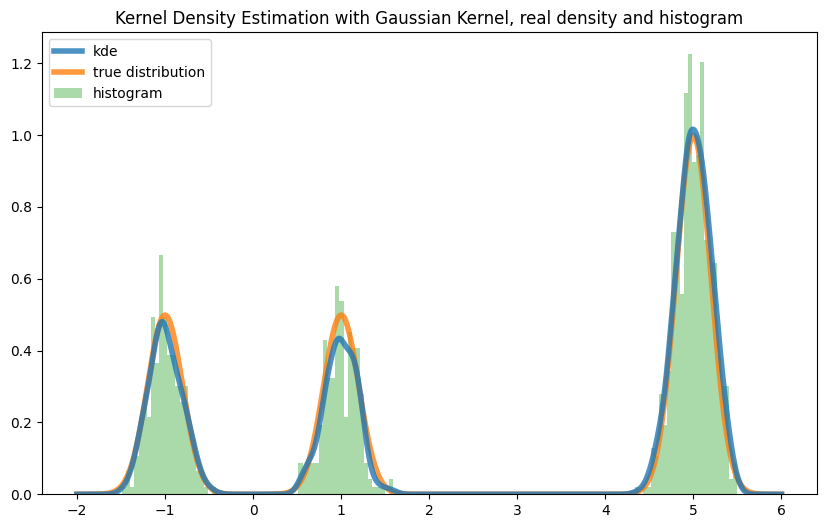

In [120]:
kd = kde(kernel_type="gaussian", bandwidth=0.07)

kd.fit(mixture)

plt.figure(figsize=(10, 6))
plt.plot(
    np.linspace(-2, 6, 5000),
    kd.transform(np.linspace(-2, 6, 5000)),
    label="kde",
    linewidth=4,
    alpha=0.8,
    zorder=10,
)
plt.plot(
    np.linspace(-2, 6, 5000),
    0.25
    * np.exp(-0.5 * ((np.linspace(-2, 6, 5000) - 1) / 0.2) ** 2)
    / (0.2 * np.sqrt(2 * np.pi))
    + 0.25
    * np.exp(-0.5 * ((np.linspace(-2, 6, 5000) + 1) / 0.2) ** 2)
    / (0.2 * np.sqrt(2 * np.pi))
    + 0.5
    * np.exp(-0.5 * ((np.linspace(-2, 6, 5000) - 5) / 0.2) ** 2)
    / (0.2 * np.sqrt(2 * np.pi)),
    label="true distribution",
    linewidth=4,
    alpha=0.8,
)
plt.hist(mixture, bins=150, alpha=0.4, density=True, label="histogram")
plt.legend()
plt.title("Kernel Density Estimation with Gaussian Kernel, real density and histogram")

We can substitute real density with density estimator and instead of integrating we can sum ei. integrate numerically.

In [129]:
estimated_density = kd.transform(np.linspace(-2, 6, 5000))
estimated_entropy = (
    -np.sum(estimated_density * np.log(estimated_density)) * (6 - (-2)) / 5000
)
print(f"Estimated entropy: {estimated_entropy}")

Estimated entropy: 0.9105278381592696


In [131]:
entropies = []
for _ in range(20):
    X_train, y_train = generate_data(1000)
    mixture = X_train[:, 0]
    kd = kde(kernel_type="gaussian", bandwidth=0.07)
    kd.fit(mixture)
    estimated_density = kd.transform(np.linspace(-2, 6, 5000))
    estimated_entropy = (
        -np.sum(estimated_density * np.log(estimated_density))
        * (6 - (-2))
        / 5000  # width of the interval
    )
    entropies.append(estimated_entropy)

print(f"Mean estimated entropy: {np.mean(entropies)}")
print(f"Standard deviation of estimated entropy: {np.std(entropies)}")

Mean estimated entropy: 0.9018408651730352
Standard deviation of estimated entropy: 0.026497063264151802


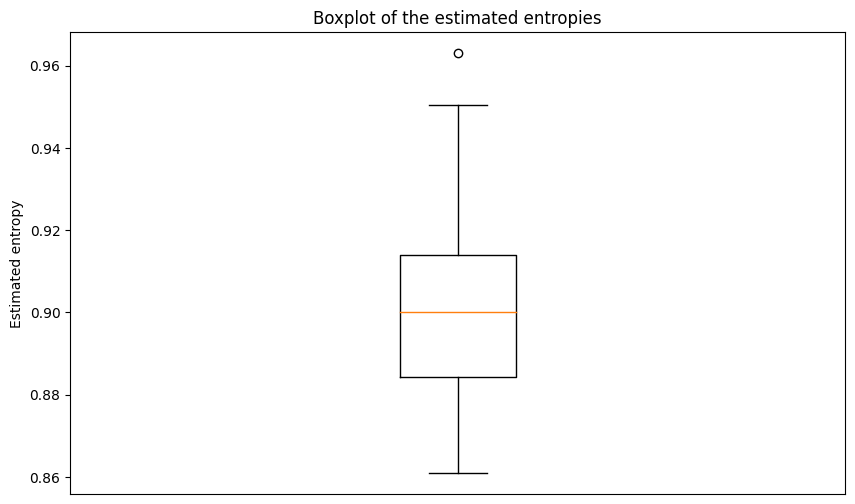

In [132]:
# boxplot of the estimated entropies
plt.figure(figsize=(10, 6))
plt.boxplot(entropies)
plt.title("Boxplot of the estimated entropies")
plt.ylabel("Estimated entropy")
plt.xticks([])
plt.show()